# Dimensionality Reduction and Clustering

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_feature_matrix(df, clustering_features):
    """Prepare features for clustering"""
    # Standardize features
    scaler = StandardScaler()
    feature_matrix = scaler.fit_transform(df[clustering_features])
    return feature_matrix

def apply_dimensionality_reduction(feature_matrix, n_components=5):
    """Use UMAP for dimensionality reduction"""
    umap_reducer = UMAP(n_components=n_components, random_state=42)
    reduced_features = umap_reducer.fit_transform(feature_matrix)
    return reduced_features

def perform_clustering(reduced_features, n_clusters=5):
    """Apply multiple clustering techniques"""
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(reduced_features)
    
    # Gaussian Mixture Models
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(reduced_features)
    
    # DBSCAN for density-based clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(reduced_features)
    
    return {
        'KMeans': kmeans_labels,
        'GMM': gmm_labels,
        'DBSCAN': dbscan_labels
    }

In [30]:
def plot_clusters(df, reduced_features, clustering_results):
    """Visualize clusters with a scatter plot"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot KMeans clusters
    sns.scatterplot(
        x=reduced_features[:, 0], y=reduced_features[:, 1], 
        hue=clustering_results['KMeans'], palette='tab10', ax=axes[0]
    )
    axes[0].set_title('KMeans Clustering')
    
    # Plot GMM clusters
    sns.scatterplot(
        x=reduced_features[:, 0], y=reduced_features[:, 1], 
        hue=clustering_results['GMM'], palette='tab10', ax=axes[1]
    )
    axes[1].set_title('Gaussian Mixture Model Clustering')
    
    # Plot DBSCAN clusters
    sns.scatterplot(
        x=reduced_features[:, 0], y=reduced_features[:, 1], 
        hue=clustering_results['DBSCAN'], palette='tab10', ax=axes[2]
    )
    axes[2].set_title('DBSCAN Clustering')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Load your data (replace with your actual dataframe)
cdf = pd.read_csv('../data/cleaned_dataset.csv')

# Define the features you want to use for clustering
clustering_features = list(cdf.columns)

# Prepare the feature matrix
feature_matrix = prepare_feature_matrix(cdf, clustering_features)

# Apply dimensionality reduction
reduced_features = apply_dimensionality_reduction(feature_matrix)

# Perform clustering
clustering_results = perform_clustering(reduced_features)

# Visualize the clustering results
plot_clusters(cdf, reduced_features, clustering_results)

/Users/moncef/Documents/vela_mip/envs/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/moncef/Documents/vela_mip/envs/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/moncef/Documents/vela_mip/envs/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


ValueError: Input contains NaN.

We now proceed to analyse the generated clusters.

In [ ]:
# Evaluate clustering performance
from sklearn.metrics import silhouette_score

# Silhouette score for each clustering method
print("Silhouette Scores:")
print("KMeans:", silhouette_score(reduced_features, clustering_results['KMeans']))
print("GMM:", silhouette_score(reduced_features, clustering_results['GMM']))
print("DBSCAN:", silhouette_score(reduced_features, clustering_results['DBSCAN']))

# Note: DBSCAN silhouette score might need special handling

# Cluster characteristics
def analyze_cluster_characteristics(df, clustering_results):
    for method, labels in clustering_results.items():
        print(f"\n{method} Cluster Analysis:")
        # Count of founders in each cluster
        cluster_counts = pd.Series(labels).value_counts()
        print("Cluster Sizes:")
        print(cluster_counts)
        
        # Average characteristics for each cluster
        cluster_profiles = df.copy()
        cluster_profiles['Cluster'] = labels
        print("\nCluster Averages:")
        print(cluster_profiles.groupby('Cluster').mean())

# Run the analysis
analyze_cluster_characteristics(cdf, clustering_results)

Silhouette Scores:
KMeans: 0.31644237
GMM: 0.31445026
DBSCAN: -0.009609886

KMeans Cluster Analysis:
Cluster Sizes:
3    3680
4    2915
0     963
2     691
1     551
Name: count, dtype: int64

Cluster Averages:
         education_level  education_institution  education_field_of_study  \
Cluster                                                                     
0               0.751817               0.911734                  0.976116   
1               1.471869               1.876588                  2.070780   
2               1.635311               2.455861                  2.341534   
3               1.472554               1.734511                  1.974185   
4               1.698113               2.184906                  2.177015   

         education_international_experience  \
Cluster                                       
0                                  0.063344   
1                                  0.201452   
2                                  0.293777   
3             

In [ ]:
import shap
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import silhouette_score

# SHAP Values for Feature Importance
def calculate_shap_values(model, X):
    """Calculate SHAP values for feature importance"""
    # Ensure the model supports prediction
    explainer = shap.KernelExplainer(model.predict, X)
    shap_values = explainer.shap_values(X)
    return shap_values

# Permutation Importance
def calculate_permutation_importance(model, X, y):
    """Calculate permutation importance"""
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    return result.importances_mean

# Cluster Re-tuning Function
def tune_clustering(feature_matrix, max_clusters=10):
    """
    Tune clustering algorithms by testing different numbers of clusters
    
    Returns:
    - Optimal number of clusters based on silhouette score
    - Silhouette scores for different cluster counts
    """
    silhouette_scores = {
        'KMeans': [],
        'GMM': []
    }
    
    # Try different numbers of clusters
    for n_clusters in range(2, max_clusters + 1):
        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans_labels = kmeans.fit_predict(feature_matrix)
        try:
            kmeans_silhouette = silhouette_score(feature_matrix, kmeans_labels)
            silhouette_scores['KMeans'].append((n_clusters, kmeans_silhouette))
        except:
            pass
        
        # Gaussian Mixture
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        gmm_labels = gmm.fit_predict(feature_matrix)
        try:
            gmm_silhouette = silhouette_score(feature_matrix, gmm_labels)
            silhouette_scores['GMM'].append((n_clusters, gmm_silhouette))
        except:
            pass
    
    # Find optimal clusters
    def find_optimal_clusters(scores):
        return max(scores, key=lambda x: x[1])
    
    optimal_kmeans = find_optimal_clusters(silhouette_scores['KMeans'])
    optimal_gmm = find_optimal_clusters(silhouette_scores['GMM'])
    
    return {
        'KMeans': optimal_kmeans,
        'GMM': optimal_gmm,
        'Full_Scores': silhouette_scores
    }

# DBSCAN Parameter Tuning
def tune_dbscan(feature_matrix, eps_range=[0.1, 0.5, 1.0], min_samples_range=[3, 5, 10]):
    """
    Tune DBSCAN parameters
    
    Returns:
    - Best parameters
    - Silhouette scores for different parameter combinations
    """
    best_score = -1
    best_params = None
    scores = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(feature_matrix)
                
                # Skip if all points in one cluster
                if len(np.unique(labels)) > 1:
                    score = silhouette_score(feature_matrix, labels)
                    scores.append({
                        'eps': eps,
                        'min_samples': min_samples,
                        'silhouette_score': score
                    })
                    
                    if score > best_score:
                        best_score = score
                        best_params = (eps, min_samples)
            except Exception as e:
                print(f"Error with eps={eps}, min_samples={min_samples}: {e}")
    
    return {
        'best_params': best_params,
        'best_score': best_score,
        'all_scores': scores
    }

# Execute the tuning
clustering_tuning = tune_clustering(feature_matrix)
dbscan_tuning = tune_dbscan(feature_matrix)

# Print results
print("KMeans Optimal Clusters:", clustering_tuning['KMeans'])
print("GMM Optimal Clusters:", clustering_tuning['GMM'])
print("DBSCAN Best Parameters:", dbscan_tuning['best_params'])

KMeans Optimal Clusters: (4, 0.10195072954287376)
GMM Optimal Clusters: (2, 0.14266258229202183)
DBSCAN Best Parameters: (0.5, 10)


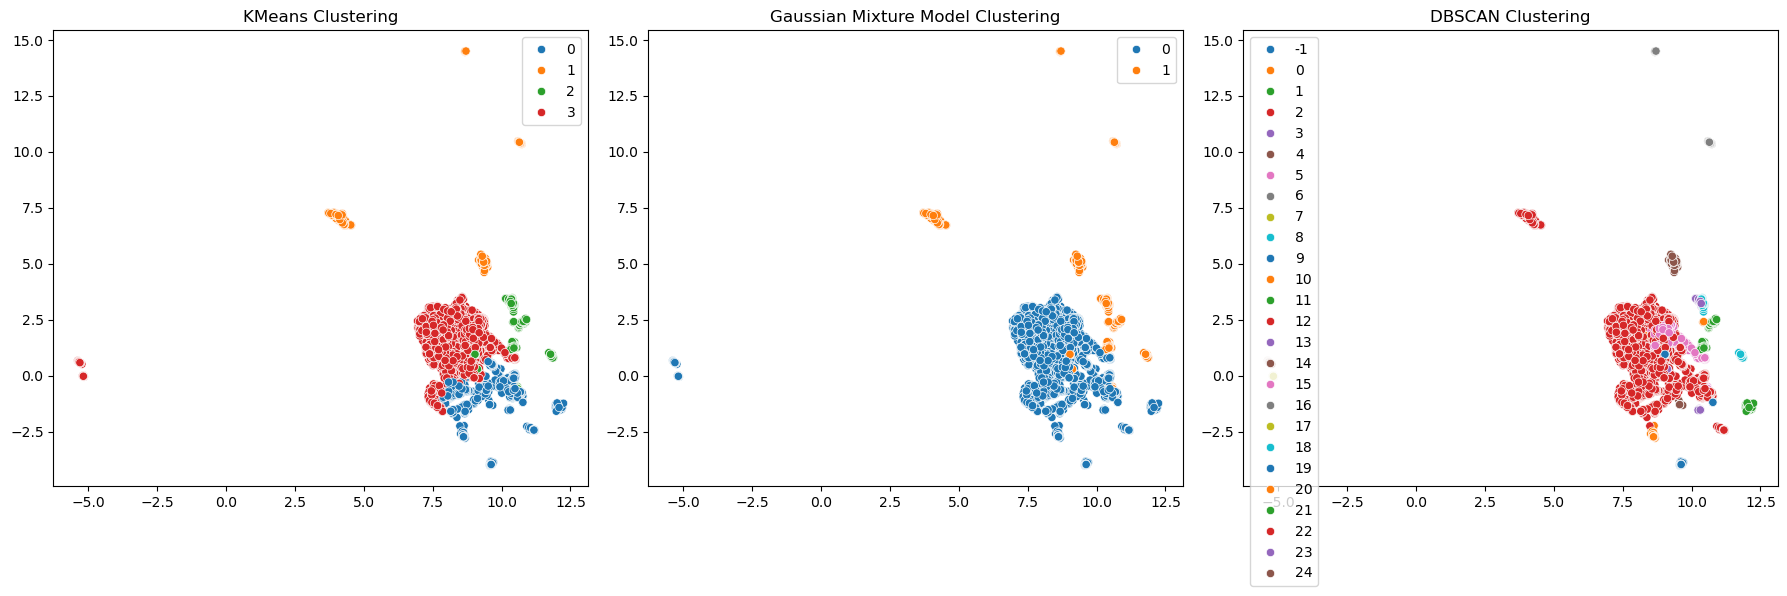

In [ ]:
# Rerun clustering with optimal parameters
def rerun_optimized_clustering(reduced_features):
    # KMeans with 4 clusters
    kmeans_optimized = KMeans(n_clusters=4, random_state=42)
    kmeans_labels_optimized = kmeans_optimized.fit_predict(reduced_features)
    
    # GMM with 2 clusters
    gmm_optimized = GaussianMixture(n_components=2, random_state=42)
    gmm_labels_optimized = gmm_optimized.fit_predict(reduced_features)
    
    # DBSCAN with tuned parameters
    dbscan_optimized = DBSCAN(eps=0.5, min_samples=10)
    dbscan_labels_optimized = dbscan_optimized.fit_predict(reduced_features)
    
    return {
        'KMeans': kmeans_labels_optimized,
        'GMM': gmm_labels_optimized,
        'DBSCAN': dbscan_labels_optimized
    }

# Get optimized clustering results
optimized_clustering_results = rerun_optimized_clustering(reduced_features)

# Visualize optimized clusters
plot_clusters(cdf, reduced_features, optimized_clustering_results)

In [ ]:
def detailed_cluster_analysis(df, clustering_results):
    for method, labels in clustering_results.items():
        print(f"\n--- {method} Cluster Analysis ---")
        
        # Create a dataframe with cluster labels
        clustered_df = df.copy()
        clustered_df['Cluster'] = labels
        
        # Basic cluster statistics
        print("\nCluster Sizes:")
        print(clustered_df['Cluster'].value_counts())
        
        # Cluster characteristics
        print("\nCluster Characteristics (Mean Values):")
        cluster_means = clustered_df.groupby('Cluster').mean()
        print(cluster_means)
        
        # Identify top distinguishing features
        print("\nTop Distinguishing Features:")
        for cluster in cluster_means.index:
            print(f"\nCluster {cluster}:")
            # Find top 5 highest and lowest features
            top_features = cluster_means.loc[cluster].nlargest(5)
            bottom_features = cluster_means.loc[cluster].nsmallest(5)
            
            print("Highest Features:")
            print(top_features)
            print("\nLowest Features:")
            print(bottom_features)


# Run detailed analysis
detailed_cluster_analysis(cdf, optimized_clustering_results)




--- KMeans Cluster Analysis ---

Cluster Sizes:
Cluster
3    6283
0    1275
2     691
1     551
Name: count, dtype: int64

Cluster Characteristics (Mean Values):
         education_level  education_institution  education_field_of_study  \
Cluster                                                                     
0               0.794510               0.943529                  1.094118   
1               1.471869               1.876588                  2.070780   
2               1.635311               2.455861                  2.341534   
3               1.604329               1.977877                  2.093904   

         education_international_experience  \
Cluster                                       
0                                  0.062745   
1                                  0.201452   
2                                  0.293777   
3                                  0.212478   

         education_publications_and_research  \
Cluster                                    

In [ ]:
from scipy import stats

def cluster_feature_significance(df, labels, clustering_features):
    """
    Perform ANOVA to check if cluster differences are statistically significant
    """
    significant_features = []
    
    # Create a dataframe with cluster labels
    clustered_df = df.copy()
    clustered_df['Cluster'] = labels
    
    for feature in clustering_features:
        # Perform one-way ANOVA
        feature_groups = [clustered_df[clustered_df['Cluster'] == cluster][feature] for cluster in np.unique(labels)]
        f_statistic, p_value = stats.f_oneway(*feature_groups)
        
        # If p-value is significant, add to list
        if p_value < 0.05:
            significant_features.append({
                'feature': feature,
                'p_value': p_value,
                'f_statistic': f_statistic
            })
    
    # Sort by significance
    significant_features.sort(key=lambda x: x['p_value'])
    
    print("Statistically Significant Features:")
    for feat in significant_features:
        print(f"{feat['feature']}: p-value = {feat['p_value']:.4f}, F-statistic = {feat['f_statistic']:.4f}")
    
    return significant_features

# Run significance test for each clustering method
for method, labels in optimized_clustering_results.items():
    print(f"\n{method} Cluster Significance:")
    cluster_significance = cluster_feature_significance(cdf, labels, clustering_features)


KMeans Cluster Significance:
Statistically Significant Features:
number_of_roles: p-value = 0.0000, F-statistic = 1140.1989
number_of_companies: p-value = 0.0000, F-statistic = 1178.6957
nasdaq_company_experience: p-value = 0.0000, F-statistic = 664.9393
big_tech_experience: p-value = 0.0000, F-statistic = 1379.8092
google_experience: p-value = 0.0000, F-statistic = 818.2734
microsoft_experience: p-value = 0.0000, F-statistic = 772.1566
big_tech_position: p-value = 0.0000, F-statistic = 1198.4494
career_growth: p-value = 0.0000, F-statistic = 5929.0450
moving_around: p-value = 0.0000, F-statistic = 2017.4858
worked_at_military: p-value = 0.0000, F-statistic = 1379.4882
bigtech_leadership: p-value = 0.0000, F-statistic = 550.8019
number_of_leadership_roles: p-value = 0.0000, F-statistic = 1098.5737
startup_experience: p-value = 0.0000, F-statistic = 610.2761
extroversion: p-value = 0.0000, F-statistic = 1315.1554
perseverance: p-value = 0.0000, F-statistic = 3661.4314
risk_tolerance: p

In [ ]:
# Perform principal component analysis for deeper insights
from sklearn.decomposition import PCA

def pca_cluster_analysis(feature_matrix, labels):
    """
    Perform PCA to understand cluster separation
    """
    # Perform PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(feature_matrix)
    
    # Plot PCA results
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_results[:, 0], pca_results[:, 1], 
                          c=labels, cmap='viridis')
    plt.title('PCA Visualization of Clusters')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(scatter)
    plt.show()
    
    # Explain variance
    print("Explained Variance Ratio:")
    print(pca.explained_variance_ratio_)

# Entropy-based cluster purity
def calculate_cluster_entropy(labels):
    """
    Calculate entropy of cluster assignments
    Lower entropy suggests more distinct clusters
    """
    from scipy.stats import entropy
    
    # Count of each label
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    
    return entropy(probabilities)
